# The *Data Acquisition Module*

We use the `tk.MFLI` instrument driver for the MFLI Lock-In amplifier.

In [1]:
import zhinst.toolkit as tk

mfli = tk.MFLI("mf1", "dev3337", interface="pcie", host="10.42.3.78")
mfli.setup()           # set up data server connection
mfli.connect_device()  # connect device to data server

Successfully connected to data server at 10.42.3.788004 api version: 6
Successfully connected to device DEV3337 on interface PCIE


The  *Data  Acquisition  Module*  corresponds  to  the  Data  Acquisition  tab  of  the  LabOne  User Interface. It enables the user to record and align time and frequency domain data from multiple instrument signal sources at a defined data rate. For more information on the *Data Acquisition Module* see the LabOne Programming Manual.

In [2]:
mfli.daq


signals:
parameters:
 - awgcontrol
 - bandwidth
 - bitmask
 - bits
 - buffercount
 - buffersize
 - clearhistory
 - count
 - delay
 - device
 - duration
 - edge
 - enable
 - endless
 - eventcount_mode
 - fft_absolute
 - fft_window
 - findlevel
 - flags
 - forcetrigger
 - grid_cols
 - grid_direction
 - grid_mode
 - grid_overwrite
 - grid_repetitions
 - grid_rowrepetition
 - grid_rows
 - grid_waterfall
 - historylength
 - holdoff_count
 - holdoff_time
 - hysteresis
 - level
 - preview
 - pulse_max
 - pulse_min
 - refreshrate
 - save_csvlocale
 - save_csvseparator
 - save_directory
 - save_fileformat
 - save_filename
 - save_save
 - save_saveonread
 - spectrum_autobandwidth
 - spectrum_enable
 - spectrum_frequencyspan
 - spectrum_overlapped
 - triggered
 - triggernode
 - type

List available sources of streaming signals ...

In [3]:
mfli.daq.signals_list()

['dio0',
 'auxin0',
 'scope0',
 'demod0',
 'demod1',
 'demod2',
 'demod3',
 'pid0_value',
 'pid0_error',
 'pid0_shift',
 'pid1_value',
 'pid1_error',
 'pid1_shift',
 'pid2_value',
 'pid2_error',
 'pid2_shift',
 'pid3_value',
 'pid3_error',
 'pid3_shift',
 'imp0',
 'imp1']

... and different signal types for a given source.

In [4]:
mfli.daq.signals_list("demod0")

['x', 'y', 'r', 'xiy', 'theta', 'frequency', 'auxin0', 'auxin1', 'dio']

### Time-domain measurement

For our simple example, we first have to make sure the data transfer of the demodulator samples is enabled and set to the right transfer rate. For a loop-back experiment we also turn on the signal output.

In [5]:
mfli.nodetree.demods[0].enable(1)
mfli.nodetree.demods[0].rate(13500)
mfli.nodetree.sigout.on(1)

1

Use the method `signals_add(..)` to specify which signals should be acquired during a measurement. The return value gives the exact node path that will be subscribed to before the measurement.

In [6]:
demod_x = mfli.daq.signals_add("demod0", "x")
demod_y = mfli.daq.signals_add("demod0", "y")

# which signal nodes have been added?
print(mfli.daq.signals)

['/dev3337/demods/0/sample.x.avg', '/dev3337/demods/0/sample.y.avg']


Use *trigger type*, *grid columns*, *grid rows* and other parameters to configure the measurement you want.

In [7]:
mfli.daq.type("continuous")
mfli.daq.grid_cols(100)
mfli.daq.grid_rows(100)

100

The measurement routine starts using the `measure(...)` method. At first, the mdoule will subscribe to the signal nodes that were previously added to the measurement. Then the measurement starts. When it is finished, the results will be added to the `results` property of the `daq` Module. 

In [8]:
mfli.daq.measure()

subscribed to: /dev3337/demods/0/sample.x.avg
subscribed to: /dev3337/demods/0/sample.y.avg
Progress: 0.0%
Progress: 6.0%
Progress: 66.0%
Finished


The results property is a dictionary with the exact signal node as its keys. The return value from `signals_add(..)` can be used to access the result of that signal. The value in the dictionary is a `DAQResult` object that contains all measurement information such as the measurement values, the time- or frequency-axis as well as meta-information.

In [9]:
mfli.daq.results[demod_x]


path:        /dev3337/demods/0/sample.x.avg
value:       (100, 100)
time:        (100,)

In [10]:
mfli.daq.results[demod_y]


path:        /dev3337/demods/0/sample.y.avg
value:       (100, 100)
time:        (100,)

In [11]:
result_x = mfli.daq.results[demod_x]

result_x.value

array([[0.17687105, 0.17686948, 0.17686892, ..., 0.17687661, 0.17687867,
        0.17687911],
       [0.17687829, 0.1768773 , 0.17687646, ..., 0.17687221, 0.17687316,
        0.17687356],
       [0.17687416, 0.17687574, 0.17687715, ..., 0.17687359, 0.17687444,
        0.17687569],
       ...,
       [0.17687166, 0.17687249, 0.17687409, ..., 0.17686543, 0.17686713,
        0.17686817],
       [0.17686746, 0.17686632, 0.17686557, ..., 0.17687962, 0.17687989,
        0.17687941],
       [0.17687887, 0.17687765, 0.17687563, ..., 0.17688278, 0.17688266,
        0.17688241]])

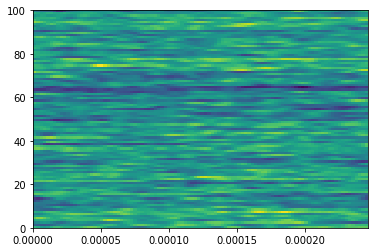

In [12]:
import matplotlib.pyplot as plt

plt.imshow(result_x.value, extent=[result_x.time[0], result_x.time[-1], 0, 100], aspect="auto")
plt.show()

### Frequency-domain measurement



In [13]:
# add the Fourier Transform of the complex signal (X + iY)
mfli.daq.signals_clear()
demod_fft = mfli.daq.signals_add("demod0", "xiy", fft=True)

# which signal nodes have been added?
print(mfli.daq.signals)

# apply trigger and grid settings
mfli.daq.type("continuous")
mfli.daq.grid_cols(1000)
mfli.daq.grid_rows(100)

['/dev3337/demods/0/sample.xiy.fft.abs.avg']


100

In [14]:
mfli.daq.measure()

subscribed to: /dev3337/demods/0/sample.xiy.fft.abs.avg
Progress: 0.0%
Progress: 6.0%
Progress: 16.0%
Progress: 27.0%
Progress: 37.0%
Progress: 55.0%
Progress: 66.0%
Progress: 82.0%
Progress: 93.0%
Finished


In [15]:
mfli.daq.results[demod_fft]


path:        /dev3337/demods/0/sample.xiy.fft.abs.avg
value:       (100, 511)
frequency:   (511,)

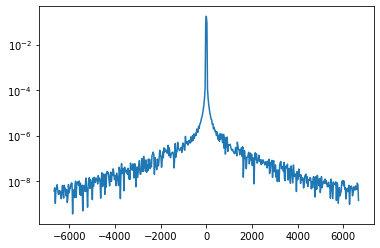

In [16]:
result_fft = mfli.daq.results[demod_fft]

plt.plot(result_fft.frequency, result_fft.value[0])
plt.yscale("log")
plt.show()